# Composing an SIR model from individual transitions using

AlgebraicPetri.jl

Simon Frost (@sdwfrost), 2023-06-13

## Introduction

This example serves as a ‘Hello World’ to composing Petri net models,
where models are ‘glued’ together using the shared states of the
individual submodels.

## Libraries

In [1]:
using AlgebraicPetri,AlgebraicPetri.TypedPetri
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs
using Catlab.WiringDiagrams
using AlgebraicDynamics.UWDDynam
using LabelledArrays
using OrdinaryDiffEq
using Plots

## Transitions

We first define a labelled Petri net that has the different types of
transition in our models. The first argument is an array of state names
as symbols (here, a generic `:Pop`), followed by the transitions in the
model. Transitions are given as
`transition_name=>((input_states)=>(output_states))`.

In [2]:
epi_lpn = LabelledPetriNet(
  [:Pop],
  :infection=>((:Pop, :Pop)=>(:Pop, :Pop)),
  :recovery=>(:Pop=>:Pop)
);

Labelled Petri nets contain four types of fields; `S`, states or
species; `T`, transitions; `I`, inputs; and `O`, outputs.

Next, we define the transmission model (from susceptibles, `S` to
infecteds, `I`) as an undirected wiring diagram using the `@relation`
macro, referring to the transitions in our labelled Petri net above
(`infection`). We include a reference to `Pop` in the definition of the
state variables to allow us to do this.

In [3]:
si_uwd = @relation (S, I) where (S::Pop, I::Pop) begin
    infection(S, I, I, I)
end;

We then use `oapply_typed`, which takes in a labelled Petri net (here,
`epi_lpn`) and an undirected wiring diagram (`si_uwd`), where each of
the boxes is labeled by a symbol that matches the label of a transition
in the Petri net, in addition to an array of symbols for each of the
rates in the wiring diagram. This produces a Petri net given by
colimiting the transitions together, and returns the
`ACSetTransformation` from that Petri net to the type system.

In [4]:
si_acst = oapply_typed(epi_lpn, si_uwd, [:β]);

To obtain the labelled Petri net, we extract the domain of the
`ACSetTransformation` using `dom`.

In [5]:
si_lpn = dom(si_acst);

We can obtain a GraphViz representation of the labelled Petri net using
`Graph`.

In [6]:
Graph(si_lpn)

We repeat for the recovery (`I` to `R`) transition.

In [7]:
ir_uwd = @relation (I, R) where (I::Pop, R::Pop) begin
    recovery(I, R)
end
ir_acst = oapply_typed(epi_lpn, ir_uwd, [:γ])
ir_lpn = dom(ir_acst)
Graph(ir_lpn)

To glue the SI and IR models together to make an SIR model, we first
define an undirected wiring diagram which contains all our states, and
two transitions.

In [8]:
sir_uwd = @relation (S, I, R) where (S::Pop, I::Pop, R::Pop) begin
    si(S, I)
    ir(I, R)
end;

We then create a `StructuredMulticospan` using this wiring diagram,
telling `oapply` that `si` in the wiring diagram corresponds to the
`si_lpn` labelled Petri net, etc.. `Open` converts a PetriNet to an
OpenPetriNet where each state is exposed as a leg of the cospan,
allowing it to be composed over an undirected wiring diagram.

In [9]:
sir_smc = oapply(sir_uwd, Dict(
    :si => Open(si_lpn),
    :ir => Open(ir_lpn),
))

StructuredMulticospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{AnonACSet{TypeLevelBasicSchema{Symbol, Tuple{:S}, Tuple{}, Tuple{:Name}, Tuple{(:sname, :S, :Name)}}, Tuple{Symbol}, Catlab.LVectors.LVector{(:S,), Int64}, NamedTuple{(:sname,), Tuple{Catlab.ColumnImplementations.DenseColumn{Symbol, Vector{Symbol}}}}}, LabelledPetriNet}, Multicospan{LabelledPetriNet, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:T, :S, :I, :O}, Tuple{(:it, :I, :T), (:is, :I, :S), (:ot, :O, :T), (:os, :O, :S)}, Tuple{:Name}, Tuple{(:tname, :T, :Name), (:sname, :S, :Name)}}, NamedTuple{(:T, :S, :I, :O), NTuple{4, Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}}, LabelledPetriNet, LabelledPetriNet}, Vector{StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:T, :S, :I, :O}, Tuple{(:it, :I, :T), (:is, :I, :S), (:ot, :O, :T), (:os, :O, :S)}, Tuple{:Name}, Tuple{(:tname, :T, :Name), (:sna

We extract the labelled Petri net by extracting the object that is the
codomain of all the legs, using the `apex` function.

In [10]:
sir_lpn = apex(sir_smc)
Graph(sir_lpn)

## Running the model

To run an ODE model from the labelled Petri net, we generate a function
that can be passed to SciML’s `ODEProblem` using `vectorfield`.

In [11]:
sir_vf = vectorfield(sir_lpn);

The initial conditions and parameter values are written as labelled
arrays.

In [12]:
u0 = @LArray [990.0, 10.0, 0.0] Tuple(snames(sir_lpn))

3-element LArray{Float64, 1, Vector{Float64}, (:S, :I, :R)}:
 :S => 990.0
 :I => 10.0
 :R => 0.0

In [13]:
p = @LArray [0.5/1000, 0.25] Tuple(tnames(sir_lpn))

2-element LArray{Float64, 1, Vector{Float64}, (:β, :γ)}:
 :β => 0.0005
 :γ => 0.25

In [14]:
tspan = (0.0, 40.0);

We can now use the initial conditions, the time span, and the parameter
values to simulate the system.


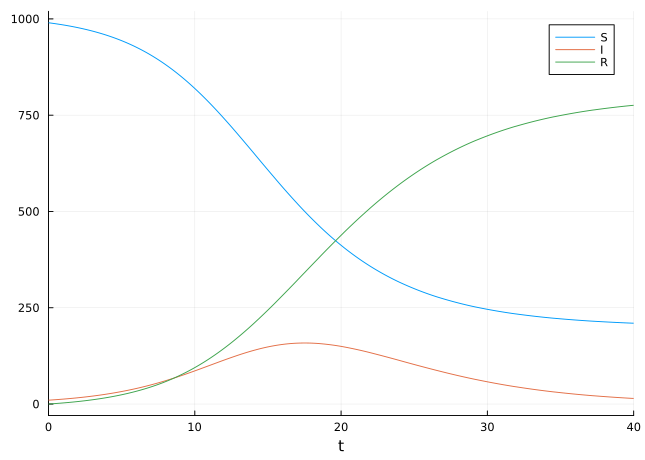

In [15]:
sir_prob = ODEProblem(sir_vf, u0, tspan, p)
sir_sol = solve(sir_prob, Rosenbrock32())
plot(sir_sol)